In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, dimension, sequence)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    X_train = X_train.transpose((0,2,1))
    X_valid = X_valid.transpose((0,2,1))
    X_test = X_test.transpose((0,2,1))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
# 뒷 padding 제거
class Chomp1d(torch.nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

In [11]:
class CausalConvolutionBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,dilation, final = False):
        super().__init__()

        padding = (kernel_size - 1) * dilation

        conv1 = nn.utils.weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size, padding = padding, dilation = dilation))
        chomp1 = Chomp1d(padding)
        relu1 = nn.LeakyReLU()

        conv2 = nn.utils.weight_norm(nn.Conv1d(out_channels, out_channels, kernel_size, padding = padding, dilation = dilation))
        chomp2 = Chomp1d(padding)
        relu2 = nn.LeakyReLU()

        # Causal network
        self.causal = torch.nn.Sequential(
            conv1, chomp1, relu1, conv2, chomp2, relu2
        )

        # Residual connection
        self.upordownsample = torch.nn.Conv1d(
            in_channels, out_channels, 1
        ) if in_channels != out_channels else None

        # Final activation function
        self.relu = torch.nn.LeakyReLU() if final else None

    def forward(self, x):
        out_causal = self.causal(x)
        res = x if self.upordownsample is None else self.upordownsample(x)
        if self.relu is None:
            return out_causal + res
        else:
            return self.relu(out_causal + res)


In [12]:
class CausalCNN(torch.nn.Module):
    def __init__(self, in_channels, channels, depth, out_channels,
                 kernel_size):
        super(CausalCNN, self).__init__()

        layers = []  # layer of convolution block
        dilation_size = 1  # initial setting

        for i in range(depth):
            in_channels_block = in_channels if i == 0 else channels
            layers += [CausalConvolutionBlock(
                in_channels_block, channels, kernel_size, dilation_size
            )]
            dilation_size *= 2  # 각 step이 지날수록 dilation이 2배로

        # last layer
        layers += [CausalConvolutionBlock(
            channels, out_channels, kernel_size, dilation_size
        )]

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [13]:
class SqueezeChannels(torch.nn.Module):
    def __init__(self):
        super(SqueezeChannels, self).__init__()

    def forward(self, x):
        return x.squeeze(2)

In [14]:
class CausalCNNEncoder(torch.nn.Module):
    '''
    (1,10,1056) tensor를 넣는다고 하자
    Causal_cnn(10,10,5,5,3)을 거치면 (1, 5, 1056)가 된다.
    AdaptiveMaxPool1d(1) 를 거치면 (1,5,1)이 된다.
    SqueezeChannels() 을 거치면 (1,5)가 된다.
    그 다음은 linear거쳐서 (1,2)가 되게 하고 이진 분류를 하면 된다.(마무리!!!!!!)
    '''
    def __init__(self, config):
        super(CausalCNNEncoder, self).__init__()
        causal_cnn = CausalCNN(
            config.in_channels, config.channels, config.depth, config.reduced_size, config.kernel_size
        )
        reduce_size = torch.nn.AdaptiveMaxPool1d(1)
        squeeze = SqueezeChannels()  # Squeezes the third dimension (time)
        linear = torch.nn.Linear(config.reduced_size, config.out_channels)
        self.network = torch.nn.Sequential(
            causal_cnn, reduce_size, squeeze, linear
        )

    def forward(self, x):
        return self.network(x.float())

# trainer 구현

In [15]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [16]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 2000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  in_channels = 19       # 처음 input의 차원의 개수 (feature수와 같다)
  channels = 19          # 중간의 차원
  depth = 5              # block 개수, block이 2이면 dilation도 2까지 한다고 생각하면 된다.
  reduced_size = 10      # 여러 block을 다 지나고 나온 차원의 개수
  out_channels = 2       # block거치고 linear 변환을 마친 차원의 개수, 여기가 2이면 이진분류
  kernel_size = 3        # kernel size인데 CasualCNNEncoder의 모든 커널의 size는 같다.

config = Config()

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [18]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [19]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


In [20]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 2000
failure(1)의 개수 : 1569


In [21]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [22]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [23]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [24]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 2141
Total number of data samples in valid_loader: 713
Total number of data samples in test_loader: 714


In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [26]:
# model, optimizer, loss_function 구현하고 결합시키기
model = CausalCNNEncoder(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [27]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/2000_tcn') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


Model saved
TRAIN LOSS = 0.0030995840672186077, TRAIN ACC = 0.4698738907052779, 
VALID LOSS = 0.0029382563573615247, VALID ACC = 0.5063113604488079, 
epoch 2


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Model saved
TRAIN LOSS = 0.0028348749678360975, TRAIN ACC = 0.5744978981784213, 
VALID LOSS = 0.002743130730044457, VALID ACC = 0.635343618513324, 
epoch 3


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Model saved
TRAIN LOSS = 0.0026762718800237835, TRAIN ACC = 0.6431574030826717, 
VALID LOSS = 0.0026018155574129807, VALID ACC = 0.6746143057503506, 
epoch 4


100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Model saved
TRAIN LOSS = 0.002547803575443587, TRAIN ACC = 0.6763194768799626, 
VALID LOSS = 0.002501145067923868, VALID ACC = 0.6830294530154277, 
epoch 5


100%|██████████| 3/3 [00:08<00:00,  2.71s/it]


Model saved
TRAIN LOSS = 0.0024450157135237826, TRAIN ACC = 0.6875291919663709, 
VALID LOSS = 0.002408885353912311, VALID ACC = 0.6942496493688639, 
epoch 6


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


Model saved
TRAIN LOSS = 0.0023521270110528083, TRAIN ACC = 0.6992059785147128, 
VALID LOSS = 0.002335856622934007, VALID ACC = 0.6984572230014026, 
epoch 7


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


TRAIN LOSS = 0.0022562442957269205, TRAIN ACC = 0.7127510509107894, 
VALID LOSS = 0.0022819591019966157, VALID ACC = 0.697054698457223, 
epoch 8


100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


TRAIN LOSS = 0.0021768174595723695, TRAIN ACC = 0.7183559084539934, 
VALID LOSS = 0.002273926644639581, VALID ACC = 0.6928471248246845, 
epoch 9


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


Model saved
TRAIN LOSS = 0.002097987880889415, TRAIN ACC = 0.7384399813171415, 
VALID LOSS = 0.0021549268491137747, VALID ACC = 0.7110799438990182, 
epoch 10


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Model saved
TRAIN LOSS = 0.002007944360619001, TRAIN ACC = 0.7524521251751518, 
VALID LOSS = 0.00210901530561407, VALID ACC = 0.7377279102384292, 
epoch 11


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Model saved
TRAIN LOSS = 0.001946706740670202, TRAIN ACC = 0.7664642690331621, 
VALID LOSS = 0.002041831466292265, VALID ACC = 0.7475455820476858, 
epoch 12


100%|██████████| 3/3 [00:07<00:00,  2.45s/it]


Model saved
TRAIN LOSS = 0.0018603745630443346, TRAIN ACC = 0.7786081270434376, 
VALID LOSS = 0.00199691263689734, VALID ACC = 0.7503506311360448, 
epoch 13


100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


Model saved
TRAIN LOSS = 0.0017794207371823534, TRAIN ACC = 0.7949556282111163, 
VALID LOSS = 0.001948071520927076, VALID ACC = 0.7545582047685835, 
epoch 14


100%|██████████| 3/3 [00:08<00:00,  2.86s/it]


Model saved
TRAIN LOSS = 0.0017064409465335452, TRAIN ACC = 0.8056982718355908, 
VALID LOSS = 0.0019723036513254986, VALID ACC = 0.7657784011220197, 
epoch 15


100%|██████████| 3/3 [00:08<00:00,  2.83s/it]


Model saved
TRAIN LOSS = 0.0016080781796556497, TRAIN ACC = 0.8323213451658104, 
VALID LOSS = 0.0019715598054219764, VALID ACC = 0.7755960729312763, 
epoch 16


100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


Model saved
TRAIN LOSS = 0.0015519372022692035, TRAIN ACC = 0.834189631013545, 
VALID LOSS = 0.0019804956953120936, VALID ACC = 0.7784011220196353, 
epoch 17


100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


Model saved
TRAIN LOSS = 0.0014813034988797084, TRAIN ACC = 0.8407286314806165, 
VALID LOSS = 0.0018550080637778005, VALID ACC = 0.7952314165497896, 
epoch 18


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


TRAIN LOSS = 0.0014324176678976017, TRAIN ACC = 0.8575432041102289, 
VALID LOSS = 0.0018862518906426129, VALID ACC = 0.7713884992987378, 
epoch 19


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


TRAIN LOSS = 0.0013811258944547494, TRAIN ACC = 0.8580102755721626, 
VALID LOSS = 0.0019025602397544188, VALID ACC = 0.7798036465638148, 
epoch 20


100%|██████████| 3/3 [00:08<00:00,  2.92s/it]


Model saved
TRAIN LOSS = 0.0012546827488555802, TRAIN ACC = 0.8766931340495095, 
VALID LOSS = 0.001801423529923213, VALID ACC = 0.7980364656381487, 
epoch 21


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Model saved
TRAIN LOSS = 0.001253716358788823, TRAIN ACC = 0.8720224194301728, 
VALID LOSS = 0.001859015828262372, VALID ACC = 0.8092566619915849, 
epoch 22


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.0012017675840314556, TRAIN ACC = 0.8762260625875758, 
VALID LOSS = 0.001805568226256511, VALID ACC = 0.7854137447405329, 
epoch 23


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0011132658502310583, TRAIN ACC = 0.8836992059785147, 
VALID LOSS = 0.0018639814469122117, VALID ACC = 0.8078541374474053, 
epoch 24


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Model saved
TRAIN LOSS = 0.0011258562456943452, TRAIN ACC = 0.8907052779075199, 
VALID LOSS = 0.0017522751114645982, VALID ACC = 0.8134642356241234, 
epoch 25


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Model saved
TRAIN LOSS = 0.0010405308673561093, TRAIN ACC = 0.9000467071461934, 
VALID LOSS = 0.0017064321592847227, VALID ACC = 0.820476858345021, 
epoch 26


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 0.001027067553379, TRAIN ACC = 0.8939747781410555, 
VALID LOSS = 0.0016922589187702323, VALID ACC = 0.8162692847124825, 
epoch 27


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0009478265119456399, TRAIN ACC = 0.9131247080803363, 
VALID LOSS = 0.0017887963737043726, VALID ACC = 0.820476858345021, 
epoch 28


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Model saved
TRAIN LOSS = 0.0008935477969135319, TRAIN ACC = 0.91359177954227, 
VALID LOSS = 0.0017065382020503574, VALID ACC = 0.8415147265077139, 
epoch 29


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.000817715008088441, TRAIN ACC = 0.9248014946286782, 
VALID LOSS = 0.0017766145803818027, VALID ACC = 0.8302945301542777, 
epoch 30


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0008689960145549427, TRAIN ACC = 0.9145259224661373, 
VALID LOSS = 0.0018008888854552452, VALID ACC = 0.8274894810659187, 
epoch 31


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0007420706100299057, TRAIN ACC = 0.93647828117702, 
VALID LOSS = 0.0017826520794738726, VALID ACC = 0.8401122019635343, 
epoch 32


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.0007147523028613362, TRAIN ACC = 0.9392807099486221, 
VALID LOSS = 0.0018121598479122467, VALID ACC = 0.8330995792426368, 
epoch 33


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.0007083502009559713, TRAIN ACC = 0.9318075665576834, 
VALID LOSS = 0.0019140670710827157, VALID ACC = 0.8330995792426368, 
epoch 34


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0007558558197123934, TRAIN ACC = 0.929472209248015, 
VALID LOSS = 0.0019534827950626068, VALID ACC = 0.8387096774193549, 
epoch 35


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Model saved
TRAIN LOSS = 0.0007204277835010312, TRAIN ACC = 0.930873423633816, 
VALID LOSS = 0.0018484871233663252, VALID ACC = 0.847124824684432, 
epoch 36


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0006922666872566629, TRAIN ACC = 0.9304063521718823, 
VALID LOSS = 0.0018258317155557128, VALID ACC = 0.8415147265077139, 
epoch 37


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Model saved
TRAIN LOSS = 0.000684112341729128, TRAIN ACC = 0.9369453526389537, 
VALID LOSS = 0.0017872578549351632, VALID ACC = 0.8485273492286115, 
epoch 38


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 0.0006152903682881569, TRAIN ACC = 0.9462867818776273, 
VALID LOSS = 0.002087880819408957, VALID ACC = 0.8387096774193549, 
epoch 39


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 0.000636623433709757, TRAIN ACC = 0.9430172816440916, 
VALID LOSS = 0.0019086915764534456, VALID ACC = 0.847124824684432, 
epoch 40


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0005881293132615835, TRAIN ACC = 0.9444184960298926, 
VALID LOSS = 0.0019678964604836527, VALID ACC = 0.844319775596073, 
epoch 41


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.0005407535663724558, TRAIN ACC = 0.9537599252685661, 
VALID LOSS = 0.001871050072920105, VALID ACC = 0.844319775596073, 
epoch 42


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0004986001892882717, TRAIN ACC = 0.9570294255021018, 
VALID LOSS = 0.001935217691504437, VALID ACC = 0.8345021037868162, 
epoch 43


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0005050176517087018, TRAIN ACC = 0.9570294255021018, 
VALID LOSS = 0.0019574357617285943, VALID ACC = 0.8429172510518934, 
epoch 44


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 0.00047506169633072484, TRAIN ACC = 0.9579635684259692, 
VALID LOSS = 0.0022156842962053683, VALID ACC = 0.8429172510518934, 
epoch 45


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.000489682947459036, TRAIN ACC = 0.9584306398879029, 
VALID LOSS = 0.002007624419173552, VALID ACC = 0.8485273492286115, 
epoch 46


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0004593092897738992, TRAIN ACC = 0.9570294255021018, 
VALID LOSS = 0.0022050827365436526, VALID ACC = 0.8485273492286115, 
epoch 47


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.00040759442879573476, TRAIN ACC = 0.966837926202709, 
VALID LOSS = 0.002223888294559709, VALID ACC = 0.8302945301542777, 
epoch 48


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.0004169037100145161, TRAIN ACC = 0.964035497431107, 
VALID LOSS = 0.0021550393288466575, VALID ACC = 0.847124824684432, 
epoch 49


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00048141608807262225, TRAIN ACC = 0.9602989257356376, 
VALID LOSS = 0.0025109598128357576, VALID ACC = 0.8345021037868162, 
epoch 50


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0005411050103636113, TRAIN ACC = 0.9537599252685661, 
VALID LOSS = 0.0023714600321621247, VALID ACC = 0.8274894810659187, 
epoch 51


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0004886619151612967, TRAIN ACC = 0.9593647828117702, 
VALID LOSS = 0.0021672916780180215, VALID ACC = 0.8429172510518934, 
epoch 52


100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


TRAIN LOSS = 0.00048491656989040137, TRAIN ACC = 0.9617001401214386, 
VALID LOSS = 0.0022324168581782018, VALID ACC = 0.8316970546984572, 
epoch 53


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0005220181610137712, TRAIN ACC = 0.952358710882765, 
VALID LOSS = 0.0020537468360483564, VALID ACC = 0.844319775596073, 
epoch 54


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Model saved
TRAIN LOSS = 0.0003860755373333615, TRAIN ACC = 0.9659037832788416, 
VALID LOSS = 0.0020034186134498884, VALID ACC = 0.85273492286115, 
epoch 55


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0003257625984677863, TRAIN ACC = 0.978514712751051, 
VALID LOSS = 0.0021600249271740584, VALID ACC = 0.85273492286115, 
epoch 56


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Model saved
TRAIN LOSS = 0.0002746742230912671, TRAIN ACC = 0.9813171415226529, 
VALID LOSS = 0.002242054126707401, VALID ACC = 0.8541374474053296, 
epoch 57


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.0002519275648593346, TRAIN ACC = 0.984119570294255, 
VALID LOSS = 0.002450190996555259, VALID ACC = 0.8457223001402524, 
epoch 58


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0002576701372639145, TRAIN ACC = 0.984119570294255, 
VALID LOSS = 0.0023638409200590757, VALID ACC = 0.8499298737727911, 
epoch 59


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00024205883412453574, TRAIN ACC = 0.9831854273703877, 
VALID LOSS = 0.002920417598387302, VALID ACC = 0.8274894810659187, 
epoch 60


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Model saved
TRAIN LOSS = 0.00031082038078170023, TRAIN ACC = 0.9743110695936479, 
VALID LOSS = 0.0026072567174678764, VALID ACC = 0.8555399719495091, 
epoch 61


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0002897302839784965, TRAIN ACC = 0.9757122839794489, 
VALID LOSS = 0.0029862235505316737, VALID ACC = 0.8457223001402524, 
epoch 62


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0002931346494786264, TRAIN ACC = 0.9724427837459131, 
VALID LOSS = 0.0025165354386285513, VALID ACC = 0.8457223001402524, 
epoch 63


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Model saved
TRAIN LOSS = 0.00022654918999885746, TRAIN ACC = 0.9859878561419897, 
VALID LOSS = 0.0024014560487460954, VALID ACC = 0.8611500701262272, 
epoch 64


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 0.00023763423323603446, TRAIN ACC = 0.9813171415226529, 
VALID LOSS = 0.0027917937844531902, VALID ACC = 0.847124824684432, 
epoch 65


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


TRAIN LOSS = 0.00025781515562912954, TRAIN ACC = 0.9813171415226529, 
VALID LOSS = 0.003051709326253198, VALID ACC = 0.8415147265077139, 
epoch 66


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.000219362417722294, TRAIN ACC = 0.9822512844465203, 
VALID LOSS = 0.002761043137955632, VALID ACC = 0.85273492286115, 
epoch 67


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00021407204788458342, TRAIN ACC = 0.9873890705277908, 
VALID LOSS = 0.002787555919288753, VALID ACC = 0.847124824684432, 
epoch 68


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 0.00018675885276781072, TRAIN ACC = 0.9878561419897244, 
VALID LOSS = 0.002937481664173399, VALID ACC = 0.8513323983169705, 
epoch 69


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 0.00016172815919868972, TRAIN ACC = 0.9897244278374592, 
VALID LOSS = 0.0028445239989988266, VALID ACC = 0.8597475455820477, 
epoch 70


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00019121677682172578, TRAIN ACC = 0.985520784680056, 
VALID LOSS = 0.003026820165412122, VALID ACC = 0.8457223001402524, 
epoch 71


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0002679334416644476, TRAIN ACC = 0.9761793554413826, 
VALID LOSS = 0.0035224528499940336, VALID ACC = 0.8345021037868162, 
epoch 72


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.0001898947781293763, TRAIN ACC = 0.9845866417561887, 
VALID LOSS = 0.0035311068926753703, VALID ACC = 0.8359046283309958, 
epoch 73


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0001961847533206971, TRAIN ACC = 0.984119570294255, 
VALID LOSS = 0.0029578769859057155, VALID ACC = 0.8583450210378681, 
epoch 74


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 0.00018773924007782142, TRAIN ACC = 0.9859878561419897, 
VALID LOSS = 0.0030781379254302336, VALID ACC = 0.85273492286115, 
epoch 75


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00014247939456906735, TRAIN ACC = 0.9892573563755255, 
VALID LOSS = 0.0030206823081488695, VALID ACC = 0.8499298737727911, 
epoch 76


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00013850484259116878, TRAIN ACC = 0.9915927136851939, 
VALID LOSS = 0.003229299317235532, VALID ACC = 0.8401122019635343, 
epoch 77


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.00014864353115928334, TRAIN ACC = 0.9892573563755255, 
VALID LOSS = 0.0034430976669718137, VALID ACC = 0.847124824684432, 
epoch 78


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00014507532987999392, TRAIN ACC = 0.9864549276039234, 
VALID LOSS = 0.003128689769942831, VALID ACC = 0.8569424964936886, 
epoch 79


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 0.00010479477180680456, TRAIN ACC = 0.9929939280709948, 
VALID LOSS = 0.0032415573927998377, VALID ACC = 0.8555399719495091, 
epoch 80


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00011958571351866252, TRAIN ACC = 0.9934609995329285, 
VALID LOSS = 0.0035568025971529026, VALID ACC = 0.8541374474053296, 
epoch 81


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0006132036611082842, TRAIN ACC = 0.9621672115833723, 
VALID LOSS = 0.003721921173085003, VALID ACC = 0.8387096774193549, 
epoch 82


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0007834470561596346, TRAIN ACC = 0.9434843531060252, 
VALID LOSS = 0.0029144719305747354, VALID ACC = 0.8288920056100981, 
epoch 83


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0005878682541045448, TRAIN ACC = 0.9425502101821579, 
VALID LOSS = 0.0023592021655902623, VALID ACC = 0.8429172510518934, 
epoch 84


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00043057056125610135, TRAIN ACC = 0.9621672115833723, 
VALID LOSS = 0.0022275444501579896, VALID ACC = 0.8457223001402524, 
epoch 85


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.0002908437316632616, TRAIN ACC = 0.9761793554413826, 
VALID LOSS = 0.0022379740926360015, VALID ACC = 0.8583450210378681, 
epoch 86


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 0.00020959508065473582, TRAIN ACC = 0.9850537132181224, 
VALID LOSS = 0.002623192140464194, VALID ACC = 0.85273492286115, 
epoch 87


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.0001551779287196052, TRAIN ACC = 0.9915927136851939, 
VALID LOSS = 0.002752804572251201, VALID ACC = 0.8611500701262272, 
epoch 88


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00012774570353089065, TRAIN ACC = 0.9939280709948622, 
VALID LOSS = 0.0029593050730679846, VALID ACC = 0.8457223001402524, 
epoch 89


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00011063437118938402, TRAIN ACC = 0.9962634283045306, 
VALID LOSS = 0.002967667696686647, VALID ACC = 0.8597475455820477, 
epoch 90


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 9.739696231332687e-05, TRAIN ACC = 0.9957963568425969, 
VALID LOSS = 0.003083764169192749, VALID ACC = 0.85273492286115, 
epoch 91


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


TRAIN LOSS = 9.451937043516505e-05, TRAIN ACC = 0.9967304997664642, 
VALID LOSS = 0.0030233679028413406, VALID ACC = 0.8569424964936886, 
epoch 92


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 8.874261053170294e-05, TRAIN ACC = 0.9962634283045306, 
VALID LOSS = 0.0034112397785106513, VALID ACC = 0.844319775596073, 
epoch 93


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 8.949978752970862e-05, TRAIN ACC = 0.9962634283045306, 
VALID LOSS = 0.0032460069255106578, VALID ACC = 0.8513323983169705, 
epoch 94


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 6.886564968575779e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.0032931287860469096, VALID ACC = 0.8555399719495091, 
epoch 95


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 7.098147950958615e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.0036638134157841538, VALID ACC = 0.8499298737727911, 
epoch 96


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 6.283909849742483e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.0035290794151862574, VALID ACC = 0.8555399719495091, 
epoch 97


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 7.283202812270493e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.0036930379994621117, VALID ACC = 0.8499298737727911, 
epoch 98


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 7.042466584090204e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.0036181084404152204, VALID ACC = 0.8569424964936886, 
epoch 99


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 7.106117196885686e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.003683894245688076, VALID ACC = 0.8555399719495091, 
epoch 100


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.00010012123004708654, TRAIN ACC = 0.9934609995329285, 
VALID LOSS = 0.0037898621084312234, VALID ACC = 0.8429172510518934, 
epoch 101


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 9.546596913597173e-05, TRAIN ACC = 0.9939280709948622, 
VALID LOSS = 0.004032025748516366, VALID ACC = 0.8513323983169705, 
epoch 102


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 9.369877389328104e-05, TRAIN ACC = 0.9929939280709948, 
VALID LOSS = 0.0039634960396594116, VALID ACC = 0.844319775596073, 
epoch 103


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.00011968111905579476, TRAIN ACC = 0.9901914992993928, 
VALID LOSS = 0.004053302767567681, VALID ACC = 0.85273492286115, 
epoch 104


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 9.992531366343534e-05, TRAIN ACC = 0.9915927136851939, 
VALID LOSS = 0.003971084388074835, VALID ACC = 0.8499298737727911, 
epoch 105


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 0.00010239684041667797, TRAIN ACC = 0.9929939280709948, 
VALID LOSS = 0.0038887909384964225, VALID ACC = 0.8457223001402524, 
epoch 106


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 0.000169413881128439, TRAIN ACC = 0.9859878561419897, 
VALID LOSS = 0.004278078654370836, VALID ACC = 0.8373071528751753, 
epoch 107


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.00021208932954732752, TRAIN ACC = 0.9859878561419897, 
VALID LOSS = 0.0036064305278729926, VALID ACC = 0.8373071528751753, 
epoch 108


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 0.00015927953945732963, TRAIN ACC = 0.9864549276039234, 
VALID LOSS = 0.0035521696526740077, VALID ACC = 0.8541374474053296, 
epoch 109


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 0.0001463150707347991, TRAIN ACC = 0.9878561419897244, 
VALID LOSS = 0.0033589435158738914, VALID ACC = 0.8499298737727911, 
epoch 110


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 0.00013711332486631824, TRAIN ACC = 0.9915927136851939, 
VALID LOSS = 0.0037459078209597465, VALID ACC = 0.8513323983169705, 
epoch 111


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 0.00011533274241783584, TRAIN ACC = 0.9892573563755255, 
VALID LOSS = 0.0035214390694509883, VALID ACC = 0.847124824684432, 
epoch 112


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 8.591272185710144e-05, TRAIN ACC = 0.9939280709948622, 
VALID LOSS = 0.003601454250608554, VALID ACC = 0.8499298737727911, 
epoch 113


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 6.951726577212075e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.0037736432080850693, VALID ACC = 0.8485273492286115, 
epoch 114


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 6.039428626026633e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.0037833165487099495, VALID ACC = 0.8555399719495091, 
epoch 115


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 8.97726728739665e-05, TRAIN ACC = 0.9953292853806632, 
VALID LOSS = 0.0036620603871713345, VALID ACC = 0.8555399719495091, 
epoch 116


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 7.669082553496097e-05, TRAIN ACC = 0.9967304997664642, 
VALID LOSS = 0.004128702225223664, VALID ACC = 0.8401122019635343, 
epoch 117


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 9.629319542440395e-05, TRAIN ACC = 0.9948622139187295, 
VALID LOSS = 0.004003235952717057, VALID ACC = 0.85273492286115, 
epoch 118


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Model saved
TRAIN LOSS = 0.0001427196818832369, TRAIN ACC = 0.9892573563755255, 
VALID LOSS = 0.003594589434031183, VALID ACC = 0.8653576437587658, 
epoch 119


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 8.431959389206518e-05, TRAIN ACC = 0.9948622139187295, 
VALID LOSS = 0.003763714562291684, VALID ACC = 0.8541374474053296, 
epoch 120


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 5.903428603992012e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.003951934494109508, VALID ACC = 0.8611500701262272, 
epoch 121


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 7.311637763026188e-05, TRAIN ACC = 0.9939280709948622, 
VALID LOSS = 0.004470203233801801, VALID ACC = 0.8457223001402524, 
epoch 122


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 7.772544465892953e-05, TRAIN ACC = 0.9957963568425969, 
VALID LOSS = 0.004191054451850152, VALID ACC = 0.8485273492286115, 
epoch 123


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 5.3577925026806535e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.0041422742780763, VALID ACC = 0.847124824684432, 
epoch 124


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 4.007423053844016e-05, TRAIN ACC = 0.9981317141522653, 
VALID LOSS = 0.0039761563002812415, VALID ACC = 0.8583450210378681, 
epoch 125


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 3.307044607426646e-05, TRAIN ACC = 0.9981317141522653, 
VALID LOSS = 0.00408511860674929, VALID ACC = 0.8611500701262272, 
epoch 126


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 5.7044734541954894e-05, TRAIN ACC = 0.9981317141522653, 
VALID LOSS = 0.004377056221473769, VALID ACC = 0.8555399719495091, 
epoch 127


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 3.9918333077120314e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.0040650901921501, VALID ACC = 0.8485273492286115, 
epoch 128


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 4.827954825092175e-05, TRAIN ACC = 0.9967304997664642, 
VALID LOSS = 0.004110546550108707, VALID ACC = 0.8583450210378681, 
epoch 129


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 4.1278051747472864e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.004388771752655757, VALID ACC = 0.847124824684432, 
epoch 130


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 4.539508803189497e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.004164873466919716, VALID ACC = 0.8569424964936886, 
epoch 131


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 3.991639338362404e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.004430505871605572, VALID ACC = 0.8583450210378681, 
epoch 132


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 2.6028406589228047e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.004333973516087043, VALID ACC = 0.8513323983169705, 
epoch 133


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 2.125789369389046e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.004384518756438438, VALID ACC = 0.8513323983169705, 
epoch 134


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 2.0467235301331986e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.004516976494942942, VALID ACC = 0.8513323983169705, 
epoch 135


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 2.0019115481242044e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.0044391195369469, VALID ACC = 0.8513323983169705, 
epoch 136


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 1.673285025295909e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.004468713619264279, VALID ACC = 0.847124824684432, 
epoch 137


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


TRAIN LOSS = 1.4683369495799363e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.004567491138800665, VALID ACC = 0.8569424964936886, 
epoch 138


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 1.6000959576342023e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.004583927224093701, VALID ACC = 0.8485273492286115, 
epoch 139


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


TRAIN LOSS = 1.4612894182931675e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.004805620472360961, VALID ACC = 0.8513323983169705, 
epoch 140


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 9.844642441801549e-06, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.0047584200306661, VALID ACC = 0.8583450210378681, 
epoch 141


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 9.510993927287435e-06, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.005023352645055442, VALID ACC = 0.8555399719495091, 
epoch 142


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 8.595782287100427e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004991909899183276, VALID ACC = 0.8569424964936886, 
epoch 143


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 1.0453934435650449e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.005128638607255206, VALID ACC = 0.8583450210378681, 
epoch 144


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 8.751052038201218e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005212155498595592, VALID ACC = 0.8569424964936886, 
epoch 145


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 8.796777962047967e-06, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.005619962536435976, VALID ACC = 0.8555399719495091, 
epoch 146


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 8.731028942686203e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005258526073097347, VALID ACC = 0.8541374474053296, 
epoch 147


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


TRAIN LOSS = 1.0997326113718629e-05, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.005585966404490852, VALID ACC = 0.8555399719495091, 
epoch 148


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 9.413562550816063e-06, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.005377717305701043, VALID ACC = 0.8513323983169705, 
epoch 149


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 5.585052306158751e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005509870082432558, VALID ACC = 0.8555399719495091, 
epoch 150


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 4.690557087861639e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005433899406631063, VALID ACC = 0.8541374474053296, 
epoch 151


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 3.6247640912103935e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005546129268148671, VALID ACC = 0.8569424964936886, 
epoch 152


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 3.4036227339458475e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005776498628699262, VALID ACC = 0.85273492286115, 
epoch 153


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 2.6935205631965526e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005626884784136714, VALID ACC = 0.8541374474053296, 
epoch 154


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 2.6067268508558223e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005946042327024826, VALID ACC = 0.8555399719495091, 
epoch 155


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 2.3091868511568588e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005856618807660246, VALID ACC = 0.8569424964936886, 
epoch 156


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 1.8398924515396008e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0058142466765801004, VALID ACC = 0.8569424964936886, 
epoch 157


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 1.7961559464632143e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005837586952626789, VALID ACC = 0.8569424964936886, 
epoch 158


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 1.674023502709023e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.006059955580873209, VALID ACC = 0.8583450210378681, 
epoch 159


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 1.6050907880105235e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.005932690217819321, VALID ACC = 0.8569424964936886, 
epoch 160


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 1.5499397429573668e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.006091670769294215, VALID ACC = 0.8569424964936886, 
epoch 161


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 1.4188839777863016e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.006275645312219649, VALID ACC = 0.85273492286115, 
epoch 162


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 1.3806756916105754e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.006119046773014363, VALID ACC = 0.8597475455820477, 
epoch 163


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 1.2814908977123808e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.006202292475760568, VALID ACC = 0.8541374474053296, 
epoch 164


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 1.4768207562591016e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.006332915260614553, VALID ACC = 0.8555399719495091, 
epoch 165


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


TRAIN LOSS = 1.4282664627646737e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.00637273584475524, VALID ACC = 0.8569424964936886, 
epoch 166


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 1.3241639779141153e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.006319907236567386, VALID ACC = 0.8541374474053296, 
epoch 167


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 1.2933654134663753e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.006315446836249524, VALID ACC = 0.8569424964936886, 
epoch 168


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 1.066898058626639e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.006496684581333925, VALID ACC = 0.8555399719495091, 
epoch 169


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 9.470149630655451e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006552099345609817, VALID ACC = 0.8569424964936886, 
epoch 170


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 9.686384226196819e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00656061152422077, VALID ACC = 0.8583450210378681, 
epoch 171


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 8.948170086523341e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0064295881426518296, VALID ACC = 0.8583450210378681, 
epoch 172


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 9.96260224450693e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00637391907637116, VALID ACC = 0.8555399719495091, 
epoch 173


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 8.317698469933163e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006607771588575622, VALID ACC = 0.8569424964936886, 
epoch 174


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 8.051984066174951e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0064285951777561185, VALID ACC = 0.85273492286115, 
epoch 175


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


TRAIN LOSS = 7.701257693101485e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006590178771908454, VALID ACC = 0.8541374474053296, 
epoch 176


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 7.146560332354199e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0067085748300646, VALID ACC = 0.8569424964936886, 
epoch 177


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 7.361228880820477e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006726223155124659, VALID ACC = 0.8569424964936886, 
epoch 178


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 7.659783171440246e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00670128099380001, VALID ACC = 0.8555399719495091, 
epoch 179


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 6.697333601563526e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006751590992257438, VALID ACC = 0.8597475455820477, 
epoch 180


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 7.022511779945317e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006853927903890944, VALID ACC = 0.8555399719495091, 
epoch 181


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 6.645139922327652e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006758436079948179, VALID ACC = 0.8555399719495091, 
epoch 182


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 6.6639079678293e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00678932014722142, VALID ACC = 0.8569424964936886, 
epoch 183


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 5.627795393238978e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0068918832722753495, VALID ACC = 0.8555399719495091, 
epoch 184


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 5.990793870160394e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006830396859542183, VALID ACC = 0.8555399719495091, 
epoch 185


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 5.576932575348773e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006764770390107956, VALID ACC = 0.8555399719495091, 
epoch 186


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 5.259100820242598e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00688587883578778, VALID ACC = 0.8569424964936886, 
epoch 187


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 5.187970348342379e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00686541412856435, VALID ACC = 0.8569424964936886, 
epoch 188


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 4.888719727169063e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006799565458364607, VALID ACC = 0.8555399719495091, 
epoch 189


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 4.695282242906187e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.007038855117969058, VALID ACC = 0.8555399719495091, 
epoch 190


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 4.99632889734401e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006917157480793614, VALID ACC = 0.8569424964936886, 
epoch 191


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 4.6411074879527045e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.007080708780596333, VALID ACC = 0.8555399719495091, 
epoch 192


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 4.899272380519827e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.007147108856457982, VALID ACC = 0.8569424964936886, 
epoch 193


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 4.985909460965911e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.007058152142614335, VALID ACC = 0.8569424964936886, 
epoch 194


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 4.1565941129052043e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.007256082532114936, VALID ACC = 0.8569424964936886, 
epoch 195


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


TRAIN LOSS = 4.174015528521562e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.007121518484171778, VALID ACC = 0.8569424964936886, 
epoch 196


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 4.026810994622111e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.007128814661151731, VALID ACC = 0.8569424964936886, 
epoch 197


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 4.0984243950402015e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.006998267113577266, VALID ACC = 0.8569424964936886, 
epoch 198


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS = 4.082510795049275e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.007282513722798266, VALID ACC = 0.8541374474053296, 
epoch 199


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


TRAIN LOSS = 3.771201658975255e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.007266687143066321, VALID ACC = 0.8569424964936886, 
epoch 200


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

TRAIN LOSS = 4.053188889767646e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.007225450091743202, VALID ACC = 0.8569424964936886, 


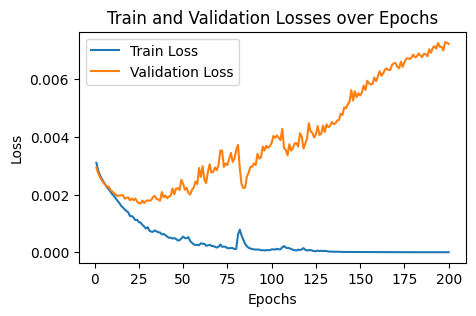

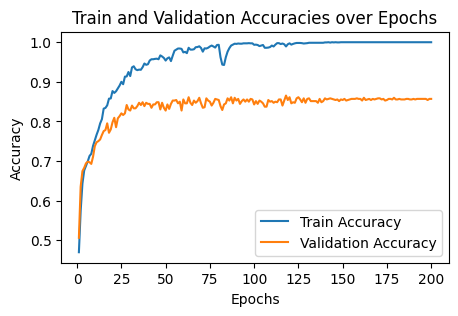

In [31]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH )
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH )

In [28]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/2000_tcn_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

Best epoch: 118
macro F1 Score: 0.8578179989944696
AUROC: 0.9267568850902184
Accuracy: 0.8585434173669467


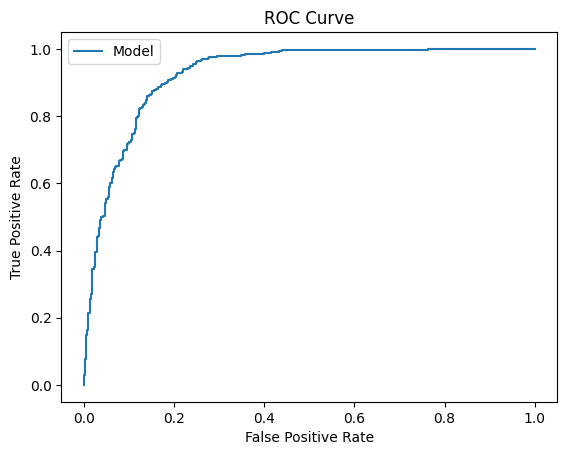

: 

In [33]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)